In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import mne

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Load dataset

In [2]:
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

## Phase-Amplitude Coupling

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

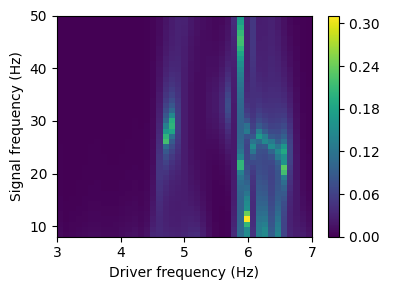

In [3]:
biotuning = compute_biotuner(1000, data = data[10], peaks_function = 'harmonic_peaks', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = False, ratios_inc = True, scale_cons_limit = 0.1) # Initialize biotuner object
pac_freqs, _ = biotuning.pac(n_values = 30, plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'duprelatour')

Different methods can be used to compute the PAC:
methods = ['ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum']

[[4.3, 39.0],
 [3.4, 20.0],
 [4.3, 49.0],
 [3.4, 47.0],
 [4.3, 40.0],
 [3.4, 48.0],
 [3.3, 45.0],
 [4.3, 41.0],
 [4.1, 42.0],
 [4.1, 8.0]]

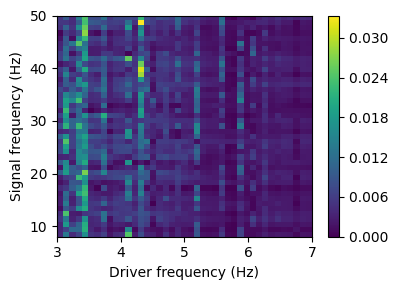

In [4]:
pac_freqs, _ = biotuning.pac(plot=True, drive_precision = 0.1, n_values = 10, max_drive_freq = 7, method = 'ozkurt')
pac_freqs

## Deriving tunings from PAC information

By computing the most frequent phase and amplitude frequencies from the 'pac_freqs' lists, we can derive a series of ratios by coupling each phase with each amplitude frequencies

In [5]:
pac_frequent = pairs_most_frequent(pac_freqs, 3)
pac_frequent

[[8.0, 42.0, 41.0], [4.3, 3.4, 4.1]]

In [6]:
ratios = []
for i in range(len(pac_frequent[0])):
    for j in range(len(pac_frequent[1])):
        ratios.append(rebound(pac_frequent[0][i]/pac_frequent[1][j]))
        
ratios = sorted(ratios)
ratios

[1.1764705882352942,
 1.1918604651162792,
 1.2209302325581395,
 1.25,
 1.2804878048780488,
 1.5073529411764706,
 1.5441176470588236,
 1.8604651162790697,
 1.9512195121951221]

Another approach to derive tuning based on the information of the Phase-Amplitude Coupling would be to compute the ratios of each pairs of phase/amplitude frequencies, and then to apply the 'scale_reduction' function to extract the most consonant intervals. This is what the pac_mode function does.

In [7]:
from biotuner.scale_construction import pac_mode
pac_mode(pac_freqs, 6, function=dyad_similarity)

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1.1337209302325582,
 1.1627906976744187,
 1.1918604651162792,
 1.4244186046511629,
 1.4705882352941178,
 1.7647058823529411]

In [8]:
pac_mode(pac_freqs, 10)

[1.1337209302325582,
 1.1627906976744187,
 1.1918604651162792,
 1.2804878048780488,
 1.4244186046511629,
 1.4705882352941178,
 1.7045454545454546,
 1.7279411764705883,
 1.7647058823529411,
 1.9512195121951221]

### Using coupled frequencies as generator interval

In [9]:
ratio = rebound(pac_freqs[0][1]/pac_freqs[0][0])
sp.Rational(ratio).limit_denominator(1000)

195/172

In [11]:
from biotuner.scale_construction import gen_interval_to_stern_brocot, generator_interval_tuning
limit_steps = 16
stern_brocot_ratio = gen_interval_to_stern_brocot (ratio)
steps = Fraction(stern_brocot_ratio).limit_denominator(16).denominator
gen_int_tuning = sorted(generator_interval_tuning(interval = ratio, steps = steps, octave = 2))
gen_int_tuning

[1.0,
 1.0617126480059673,
 1.1337209302325582,
 1.2036858509369976,
 1.285323147647377,
 1.3646438426320615,
 1.457197754600224,
 1.5471252867049534,
 1.652055593878161,
 1.7540083192294529,
 1.8729700046874498]

## Deriving euclidian rhythms from PAC information

In [13]:
from biotuner.dictionaries import *
from biotuner.rhythm_construction import *
pac_scale = pac_mode(pac_freqs, 10, function=dyad_similarity)
euclid_final, cons = consonant_euclid(pac_scale, n_steps_down = 3, limit_denom = 4, 
                                      limit_cons =1, limit_denom_final = 100)
interval_vectors = [interval_vector(x) for x in euclid_final]
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_final, interval_vectors, euclid_referent

([[1, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0],
  [1, 1, 0],
  [1, 1, 0, 1, 1, 0],
  [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]],
 [[3],
  [4],
  [4, 4],
  [4, 4, 4],
  [3, 3],
  [3, 3, 3, 3],
  [2, 2, 2],
  [2, 2, 2, 2],
  [1, 2],
  [1, 2, 1, 2],
  [1, 2, 1, 2, 1, 2, 1, 2]],
 ['None',
  'None',
  'None',
  'None',
  'None',
  'It is periodic with four repetitions of E(1,3) = [100]. It is the (12/8)-time Fandago clapping pattern in the Flamenco music of southern Spain, where 1 denotes a loud clap and 0 soft clap.',
  'None',
  'None',
  'A common Afro-Cuban drum pattern when started on the second onset as in [101]. For example, it is the conga rhythm of the (6/8)-time Swing Tumbao. It is common in Latin American music, as for example in the Cueca, and the coros de clave. It is common in Arabic music, as for example in the Al Taer rhy